# Build a simple environment

In [1]:
import gym

import numpy as np

from IPython.display import clear_output
from IPython import display
import random
import matplotlib.pylab as plt
import copy
import time

In [11]:
class SimpleCorridor(gym.Env):
    def __init__(self, config):
        self.length = config["corridor_length"]
        self.mode = config["mode"] # "fixed" or "random"
        
        if self.mode == "fixed":
            self.start_pos = 0
            self.end_pos = self.length-1
        elif self.mode == "random":
            self.start_pos, self.end_pos = random.sample(range(self.length),2)
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(0.0, self.length, shape=(1,),dtype='int32')

    def reset(self):
        self.cur_pos = self.start_pos
        return self.cur_pos

    def step(self, action):
        if action == 0 and self.cur_pos > 0: # walk left
            self.cur_pos -= 1
        if action == 1 and self.cur_pos < self.length-1:
            self.cur_pos += 1
        done = self.cur_pos == self.end_pos
        reward = 1.0 if done else 0.0
        return self.cur_pos , reward, done, {} 
    def render(self, mode="rgb_array"):
        s = ''
        for i in range(self.length):
            if i == self.cur_pos:
                s = s+'A'
            elif i == self.end_pos:
                s= s + "T"
            else:
                s = s+'_'
        print(s)

In [21]:
env = SimpleCorridor({"corridor_length": 20, "mode":"fixed"})
env.reset()
env.render()

A__________________T


## Pretraining random walk

In [22]:
obs = env.reset()
done = False

while not done:
    display.clear_output(wait=True)
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    print("state= ", obs, ",reward = ",  reward, ",done = ", done)
    time.sleep(0.1)

__A________________T
state=  2 ,reward =  0.0 ,done =  False


KeyboardInterrupt: 

# Value Iteration : Training

In [23]:
theta = 1e-5
l = 0.95 # lambda

env.V = np.random.rand(env.length) # random initialization of all states
env.V[env.end_pos] = 0

delta = 1
while delta > theta:
    delta = 0
#for _ in range(10):
    for s in range(env.length): # swipe over all possible states
        v = env.V[s]
        Vreachable = []
        for a in range(2): # range over two actions
            env.cur_pos = s
            sp, r, done, info = env.step(a)
            Vreachable.append(r + l*env.V[sp])
        env.V[s] = max(Vreachable)
        delta = max(delta,abs(v - env.V[s]))
#        print(delta)

In [24]:
def policyGreedy(s):
    li = max(s-1,0)
    lr = min(s+1,env.length-1)
    Vlr = [env.V[li], env.V[lr]]
    return np.argmax(Vlr)
    


## post training walk

In [25]:
obs = env.reset()
done = False

while not done:
    display.clear_output(wait=True)
    obs, reward, done, _ = env.step(policyGreedy(obs))
    env.render()
    print("state= ", obs, ",reward = ",  reward, ",done = ", done)
    time.sleep(0.2)

___________________A
state=  19 ,reward =  1.0 ,done =  True


In [8]:
env.V

array([ 8.35382475,  8.79350852,  9.25633309,  9.74351644, 10.25634061,
        9.74352358, 10.2563474 ,  9.74353003,  9.25635353,  8.79353586])

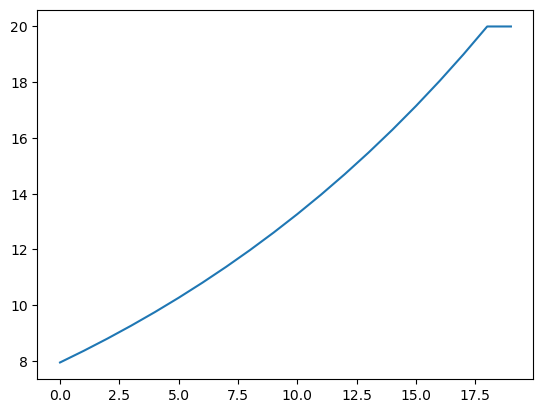

In [26]:
plt.plot(env.V)

# Policy iteration

In [38]:
theta = 1e-5
l = 0.95 # lambda

# initialize V
env.V = np.random.rand(env.length) # random initialization of all states
env.V[env.end_pos] = 0

# initialize pi
env.pi = {s:env.action_space.sample() for s in range(env.length)}

In [42]:
policyStable=False

while not policyStable:
    
    # policy evaluatioan
    delta = 1
    while delta > theta:
        delta = 0
        for s in range(env.length): # swipe over all possible states
            v = env.V[s]
            env.cur_pos = s
            sp, r, done, info = env.step(a)
            env.V[s] = (r+l*env.V[sp])
            delta = max(delta,abs(v - env.V[s]))
            
            
    #policy iteration
    policyStable = True
    for s in range(env.length):
        a_old = env.pi[s]
        x = []
        for a in range(2):
            env.cur_pos = s
            sp,r,done,info = env.step(a)
            x.append(r + l*env.V[sp])
        env.pi[s] = np.argmax(x)
        if a_old != env.pi[s]:
            policyStable = False    

## Walk after policy iteration training

In [46]:
obs = env.reset()
done = False

while not done:
    display.clear_output(wait=True)
    obs, reward, done, _ = env.step(env.action_space.sample())
#    obs, reward, done, _ = env.step(env.pi[obs])
    env.render()
    print("state= ", obs, ",reward = ",  reward, ",done = ", done)
    time.sleep(0.2)

___________________A
state=  19 ,reward =  1.0 ,done =  True
